In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os

搜索当前文件夹获取文件名

In [2]:
def search_dir(directory):
    files = os.listdir(directory)
    
    original_file = None
    test_file = []
    
    for f in files:
        if f.endswith(".XLS"):
            if f.startswith("Reinjection"):
                test_file.append(f)
            elif f.startswith("Original"):
                original_file = f
                
    return original_file, test_file

In [3]:
def generate_file_path(directory, name):
    return directory + "\\" + name

加载、合并original data的函数

In [4]:
def load_and_concate_original_data(path):
    dataframe = pd.DataFrame()
    data = xlrd.open_workbook(path)
    header_list = ['T', 'Cam_id', 'EQ_id', 'Lat_D', 'Com_Sync_id', 'OBJ_Sync_id', 'OBJ_CIPV_ID', 'OBJ_CIPV_Lost', 'OBJ_id', 'OBJ_Re_Long_V', 'OBJ_Long_D']
    for sheet in data.sheets():
        name = sheet.name
        print("Processing:", name)
        
        # are you sure that every sheet of the original data has a header???
        df = pd.read_excel(path, names = header_list, sheet_name = name)
        dataframe = pd.concat([dataframe, df], ignore_index = True)
    return dataframe

加载、合并test data的函数

In [29]:
# check whether the first row of the data is the same as the header list
def check_first_row(dataframe, header_list):
    return list(dataframe.loc[0]) == header_list

In [37]:
def load_and_concate_test_data(path):
    dataframe = pd.DataFrame()
    old_header_list = ["t[s]", 
                             "EYEQDG_CMN_Params_s.COM_Cam_Frame_ID_b32[]", 
                             "EYEQDG_CMN_Params_s.COM_EyeQ_Frame_ID_b32[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvO_Params_as._0_.OBJ_Lat_Distance_b12[]",
                             "EYEQDG_CMN_Params_s.COM_Sync_Frame_ID_b8[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvH_Params_s.OBJ_Sync_ID_b8[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvH_Params_s.OBJ_VD_CIPV_ID_b8[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvH_Params_s.OBJ_VD_CIPV_Lost_b2[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvO_Params_as._0_.OBJ_ID_b8[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvO_Params_as._0_.OBJ_Relative_Long_Velocity_b13[]",
                             "EYEQDG_OBJT_Params_s.EYEQDG_OBJTvO_Params_as._0_.OBJ_Long_Distance_b14[]"]
    header_list = ['T', 'Cam_id', 'EQ_id', 'Lat_D', 'Com_Sync_id', 'OBJ_Sync_id', 'OBJ_CIPV_ID', 'OBJ_CIPV_Lost', 'OBJ_id', 'OBJ_Re_Long_V', 'OBJ_Long_D']
    data = xlrd.open_workbook(path)
    # note down the name of the last sheet because we need to delete the final 8 rows that are not numeric data
    final_sheet_name = data.sheets()[-1].name
    
    for sheet in data.sheets():
        name = sheet.name
        print("Processing:", name)
        
        if name == final_sheet_name:
            df = pd.read_excel(path, names = header_list, header = None, sheet_name = name, skipfooter = 8)
        else:
            df = pd.read_excel(path, names = header_list, header = None, sheet_name = name)
            
        # not sure whether which sheet will include the header row, so use this function to check
        if check_first_row(df, old_header_list):
            df = df.drop(0)
            
        dataframe = pd.concat([dataframe, df], ignore_index = True, sort=False)

    return dataframe

将数据合并到最后一行

In [7]:
def shift_columns(dataframe):
    dataframe_copy = dataframe.copy()
    iters = dataframe_copy.shape[1]
    for index, col in enumerate(dataframe.columns[2:]):
        dataframe_copy[col] = dataframe_copy[col].shift(index+1)
    return dataframe_copy

In [8]:
def dropnan(dataframe):
    return dataframe.dropna(subset = ['Cam_id'])

画图

In [428]:
# not sure about what data should lie on Y-axis, default is Lat_D
def plot(dataframe, to_analysis = 'Lat_D'):
    # matplotlib
    fig = plt.figure(figsize=(20,8),dpi=80)
    ax = plt.subplot(111)
    plt.plot(dataframe['Cam_id'], dataframe[to_analysis], color = 'r')
    plt.xlabel('Cam_id', color = 'b', fontsize = 15)
    plt.ylabel(to_analysis, color = 'b', fontsize = 15)

In [429]:
# not sure about what data should lie on Y-axis, default is Lat_D
def plot_tests(df_array, to_analysis = 'Lat_D'):
    fig = plt.figure(figsize=(20,8),dpi=80)
    ax = plt.subplot(111)
    name_list = []
    colors = ["r", "g", "b", "y", "c"]
    for i in range(len(df_array)):
        df = df_array[i]
        name_list.append("Test" + str(i+1))
        plt.plot(df['Cam_id'], df[to_analysis], color = colors[i])
    plt.xlabel('Cam_id', color = 'b', fontsize = 15)
    plt.ylabel(to_analysis, color = 'b', fontsize = 15)
    ax.legend(name_list, loc=1, fontsize=12)

除去重复camera_id的行（保留首个）

In [115]:
def remove_dup(dataframe):
    # default is keeping the first data of cuplicate, subject to change
    dataframe.drop_duplicates(subset='Cam_id', inplace=True)
    return dataframe

除去异常值

In [73]:
# outlier_range is an array of outlier values? A range?
def remove_outlier(dataframe, outlier_range, to_detect = 'OBJ_Long_D'):
    filt = (dataframe[to_detect].isin(outlier_range)) # currently set to an array of outlier values
    after_remove = dataframe.drop(dataframe[filt].index)
    after_remove = after_remove.reset_index().drop(["index"], axis = 1)
    return after_remove

封装先前的函数

In [111]:
def generate_dataframe(directory):
    original_name, test_names = search_dir(directory)
    test_df_array = []
    original_path = generate_file_path(directory, original_name)
    original_df = remove_dup(dropnan(shift_columns(load_and_concate_original_data(original_path))))
    # -200 is for test purpose
    original_df = remove_outlier(original_df, [-200])

    for n in test_names:
        path = generate_file_path(directory, n)
        test_df = remove_dup(dropnan(shift_columns(load_and_concate_test_data(path))))
        # -200 is for test purpose
        test_df = remove_outlier(test_df, [-200])
        test_df_array.append(test_df)
    return original_df, test_df_array

数据合并和计算

In [266]:
def drop_zero_and_na(dataframe):
    new = dataframe.reset_index().drop(["index"], axis = 1)
    new = new.drop(dataframe[dataframe["Cam_id"] == 0].index)
    new = new.dropna()
    return new

In [272]:
def merge_and_calculate(original, test_list, to_analysis = 'Lat_D'):
    original_selected = original.loc[:, ["Cam_id", to_analysis]]
    test_selected = []
    for df in test_list:
        data = df.loc[:, ["Cam_id", to_analysis]]
        test_selected.append(data)
    merged = pd.merge(original_selected, test_selected[0], on = "Cam_id", how = "outer")
    for index in range(1, len(test_selected)):
        merged = pd.merge(merged, test_selected[index], on = "Cam_id", how = "outer")
    name_list = [to_analysis + "_test" + str(j+1) for j in range(len(test_selected))]
    merged.columns = ["Cam_id", "Original"] + name_list
    merged = drop_zero_and_na(merged)
    merged = merged.reset_index().drop(["index"], axis = 1)
    merged["test_mean"] = merged[name_list].mean(axis=1)
    merged["test_std"] = merged[name_list].std(axis=1)
    return merged
    

画图：mean, std, original data

In [299]:
def plot_statistics(dataframe, include_original = True, include_mean = True, include_std = True):
    fig = plt.figure(figsize=(20,8),dpi=80)
    ax = plt.subplot(111)
    legend_list = []
    if include_original:
        ax.plot(dataframe["Cam_id"], dataframe["Original"], color = "deepskyblue")
        legend_list.append('Original data')
    if include_mean:
        ax.plot(dataframe["Cam_id"], dataframe["test_mean"], color = "forestgreen")
        legend_list.append('Mean')
    if include_std:
        ax.plot(dataframe["Cam_id"], dataframe["test_std"], color = "orange")
        legend_list.append('Std')
    ax.legend(legend_list, loc=1, fontsize=12)

侦测std过大的camera_id

In [333]:
def large_std_cam_id(dataframe, std_lower_bound):
    #cam_id_list = []
    filt = (dataframe["test_std"] >= std_lower_bound)
    return list(dataframe[filt]["Cam_id"])

将camera_id对应转化成original的t[s]

In [334]:
def covert_cam_id_to_time(original, cam_id):
    filt = (original["Cam_id"].isin(cam_id))
    filtered_t = original[filt]["T"]
    return filtered_t

将t[s]变成区间型

In [422]:
def convert_t_to_interval(time_and_id):
    interval = []
    indices = time_and_id.index
    current = 0
    start = indices[current]
    length = 1
    while True:
        try:
            end = indices[current + 1]
            if end != start + length:
                length = 1
                if start == indices[current]:
                    interval.append(str(start))
                else:
                    interval.append(str(start)+"-"+str(indices[current]))
                current += 1
                start = indices[current]
            else:
                length += 1
                current += 1
        except:
            if length != 1:
                interval.append(str(start)+"-"+str(end))
            else:
                interval.append(str(end))
            break
    return interval    

数据初步处理以及画图测试

In [39]:
directory = 'C:\\Users\\Z0050908\\Documents\\Jupyter_scipt\\group5\\group5\\Result analysis'
original_name, test_names = search_dir(directory)
test_df_array = []
original_df = load_and_concate_original_data(generate_file_path(directory, original_name))

# need some timing process in this part to get the time of running these data
for n in test_names:
    path = generate_file_path(directory, n)
    test_df = load_and_concate_test_data(path)
    test_df_array.append(test_df)

Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet5
Processing: Sheet6
Processing: Sheet7
Processing: Sheet8
Processing: Sheet9
Processing: Sheet10
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet5
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4


In [54]:
original_df

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.002703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6
1,0.004612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1324.0,NaN
2,0.006779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
3,0.008963,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,0.010822,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
602159,1233.103121,57460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602160,1233.104960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7
602161,1233.106325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1324.0,NaN
602162,1233.108562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN


In [55]:
test_df_array[3]

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.00220594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200
1,0.00346618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,0.00475693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,0.00625871,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,0.00747395,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
249482,385.679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148,NaN,NaN
249483,385.68,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
249484,385.681,NaN,NaN,NaN,NaN,NaN,148,NaN,NaN,NaN,NaN
249485,385.683,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN


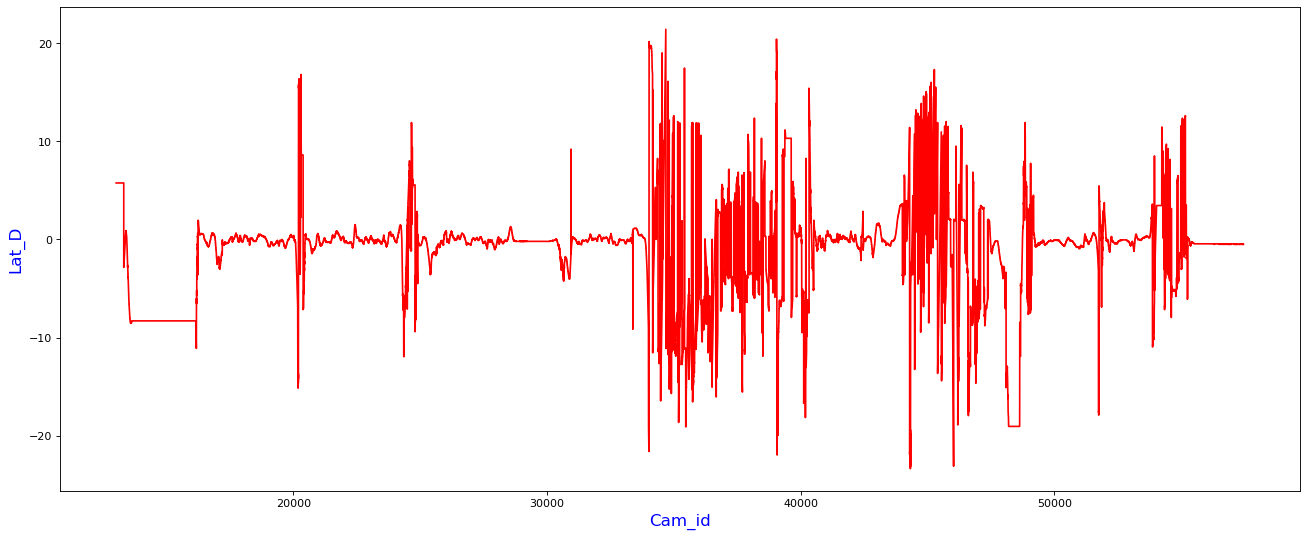

In [430]:
processed_original = dropnan(shift_columns(original_df))
plot(processed_original)

In [431]:
test_df_processed = []
for df in test_df_array:
    processed = dropnan(shift_columns(df))
    test_df_processed.append(processed)

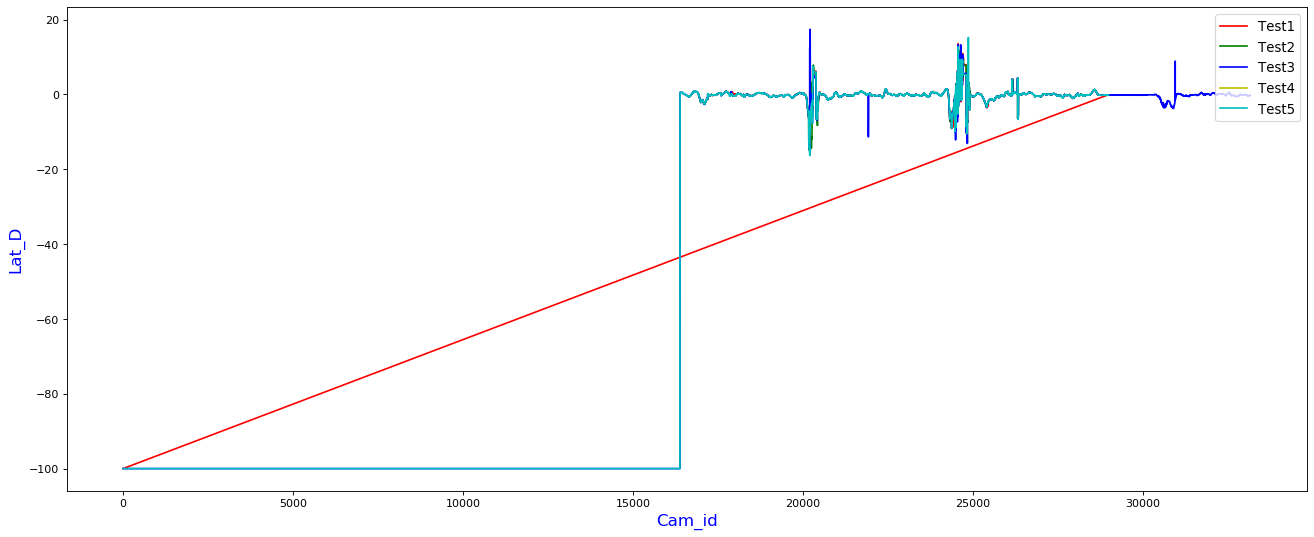

In [432]:
plot_tests(test_df_processed)

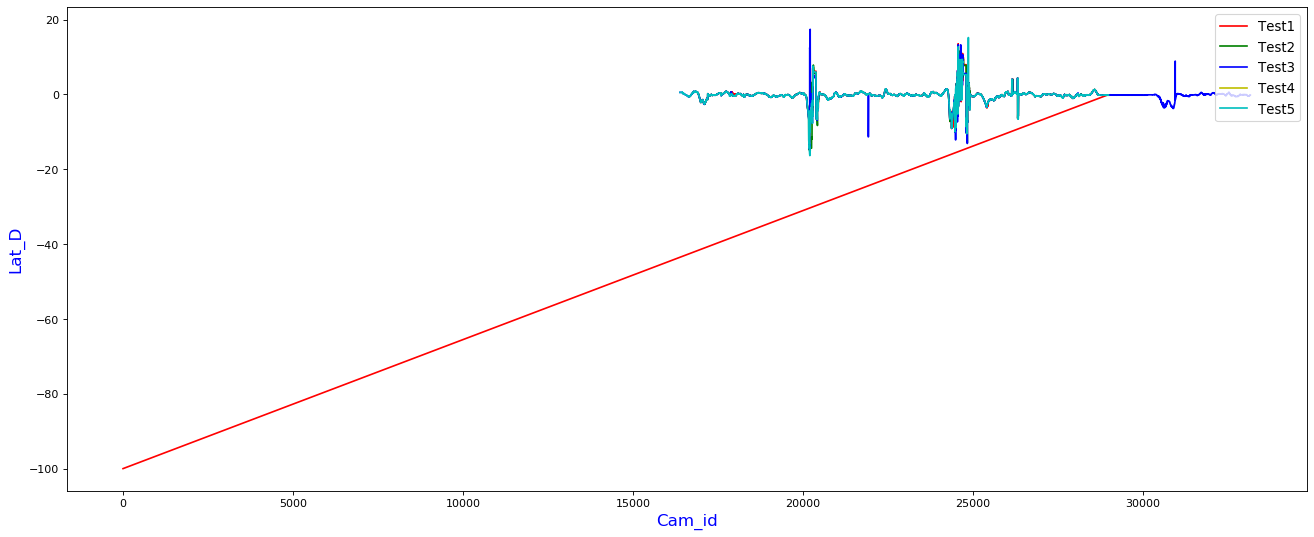

In [434]:
test_df_removed = []
for df in test_df_processed:
    # here, the outlier range is set to only -200, subject to change
    after_remove = remove_outlier(df, [-200])
    test_df_removed.append(after_remove)
plot_tests(test_df_removed)

In [76]:
test_df_removed[1]

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.0167425,16646,279,-0.6,24,24,1,0,1,7474,15
1,0.0323397,16646,279,-0.6,24,24,1,0,1,7474,15.1
2,0.0472966,16647,280,-0.6,25,25,1,0,1,7474,15.1
3,0.0627048,16648,280,-0.6,25,25,1,0,1,7474,15.15
4,0.0779177,16648,281,-0.6,26,26,1,0,1,7474,15.25
...,...,...,...,...,...,...,...,...,...,...,...
22240,343.742,29036,12669,-0.15,126,126,153,2,153,7465,5.35
22241,343.758,29037,12670,-0.15,126,126,153,2,153,7464,5.3
22242,343.771,29037,12670,-0.15,127,127,153,2,153,7464,5.25
22243,343.788,29038,12671,-0.15,127,127,153,2,153,7464,5.25


In [108]:
remove_dup(test_df_removed[1])

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.0167425,16646,279,-0.6,24,24,1,0,1,7474,15
2,0.0472966,16647,280,-0.6,25,25,1,0,1,7474,15.1
3,0.0627048,16648,280,-0.6,25,25,1,0,1,7474,15.15
5,0.093307,16649,282,-0.6,26,26,1,0,1,7474,15.25
7,0.123297,16650,283,-0.6,28,28,1,0,1,7474,15.3
...,...,...,...,...,...,...,...,...,...,...,...
22236,343.68,29034,12667,-0.2,124,124,153,2,153,7466,5.4
22238,343.71,29035,12668,-0.2,124,124,153,2,153,7465,5.4
22240,343.742,29036,12669,-0.15,126,126,153,2,153,7465,5.35
22241,343.758,29037,12670,-0.15,126,126,153,2,153,7464,5.3


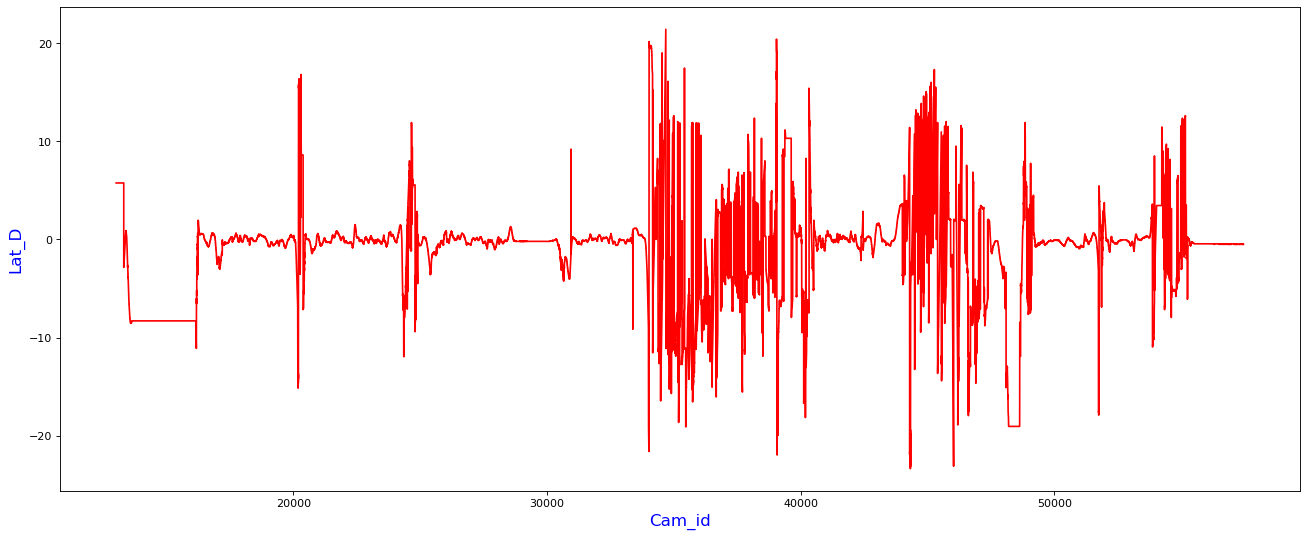

In [435]:
original_removed = remove_outlier(processed_original, [-200])
plot(original_removed)

用scatter查看data点位分布

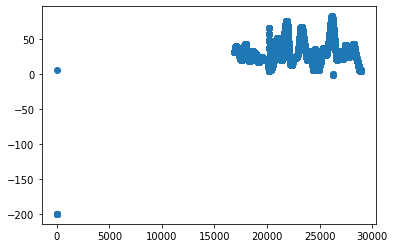

In [78]:
plt.scatter(test_df_processed[0]['Cam_id'], test_df_processed[0]['OBJ_Long_D'])

测试封装（ok）

Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet5
Processing: Sheet6
Processing: Sheet7
Processing: Sheet8
Processing: Sheet9
Processing: Sheet10
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet5
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4
Processing: Sheet1
Processing: Sheet2
Processing: Sheet3
Processing: Sheet4


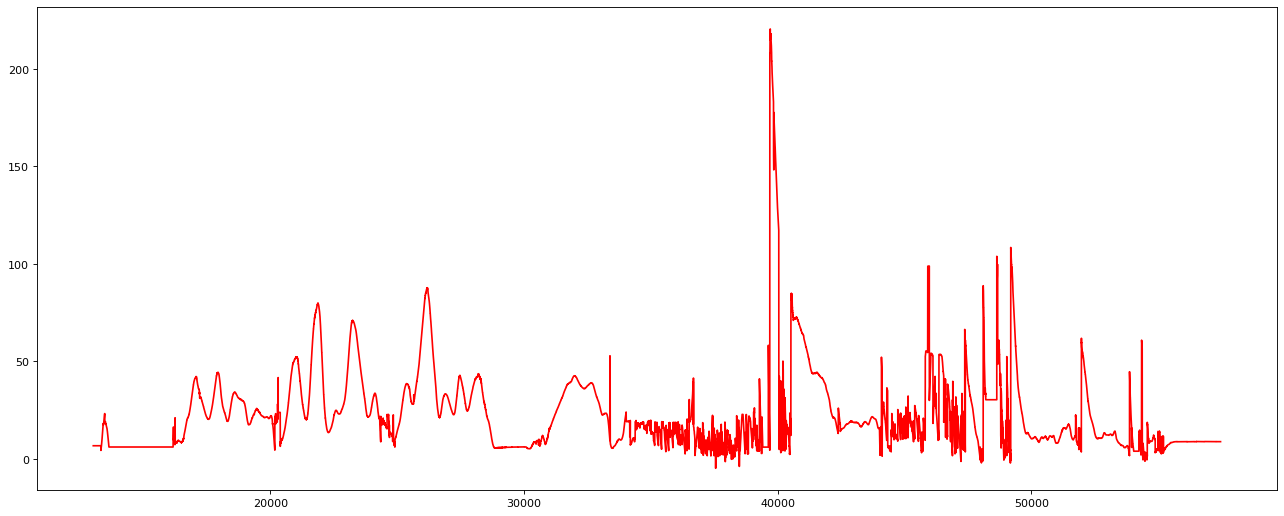

In [112]:
directory = 'C:\\Users\\Z0050908\\Documents\\Jupyter_scipt\\group5\\group5\\Result analysis'
ori, test_l = generate_dataframe(directory)
plot(ori)

In [146]:
ori

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.020199,13012.0,12860.0,5.75,60.0,60.0,0.0,0.0,2.0,1324.0,6.6
1,0.059645,13013.0,12861.0,5.75,62.0,62.0,0.0,0.0,2.0,1324.0,6.6
2,0.078400,13014.0,12862.0,5.75,63.0,63.0,0.0,0.0,2.0,1324.0,6.6
3,0.117429,13015.0,12863.0,5.75,64.0,64.0,0.0,0.0,2.0,1324.0,6.6
4,0.135353,13016.0,12864.0,5.75,64.0,64.0,0.0,0.0,2.0,1324.0,6.6
...,...,...,...,...,...,...,...,...,...,...,...
44163,1232.997135,57456.0,57294.0,-0.50,207.0,207.0,0.0,0.0,95.0,1324.0,8.7
44164,1233.013485,57457.0,57295.0,-0.50,208.0,208.0,0.0,0.0,95.0,1324.0,8.7
44165,1233.032408,57458.0,57296.0,-0.45,208.0,208.0,0.0,0.0,95.0,1324.0,8.7
44166,1233.068208,57459.0,57297.0,-0.50,210.0,210.0,0.0,0.0,95.0,1324.0,8.7


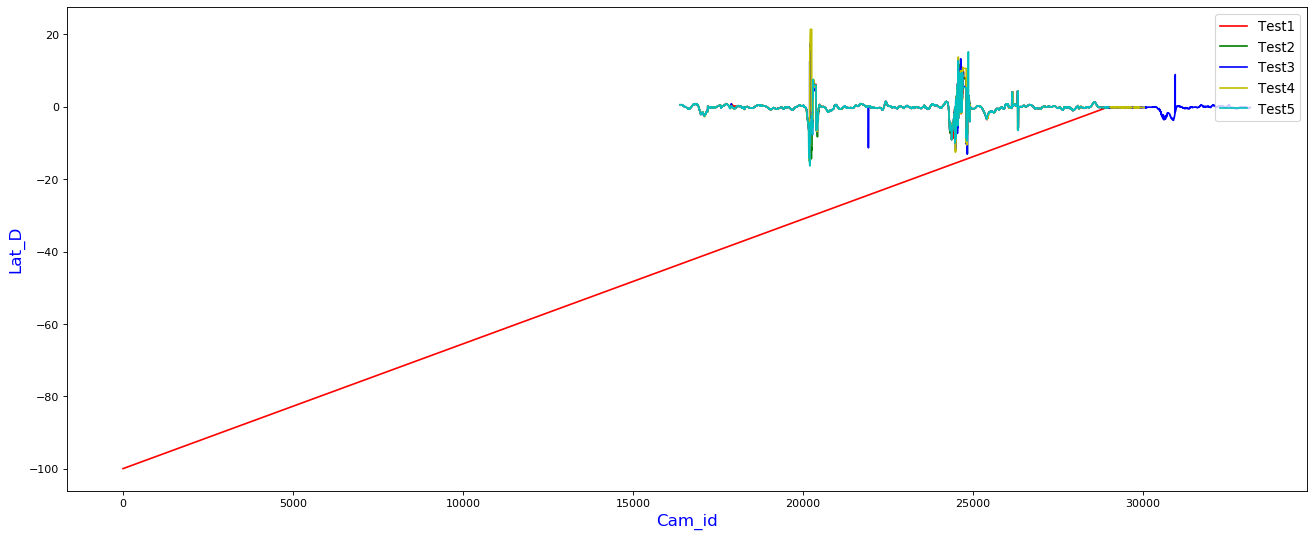

In [436]:
plot_tests(test_l)

In [114]:
test_l[1]

,T,Cam_id,EQ_id,Lat_D,Com_Sync_id,OBJ_Sync_id,OBJ_CIPV_ID,OBJ_CIPV_Lost,OBJ_id,OBJ_Re_Long_V,OBJ_Long_D
0,0.0167425,16646,279,-0.6,24,24,1,0,1,7474,15
1,0.0472966,16647,280,-0.6,25,25,1,0,1,7474,15.1
2,0.0627048,16648,280,-0.6,25,25,1,0,1,7474,15.15
3,0.093307,16649,282,-0.6,26,26,1,0,1,7474,15.25
4,0.123297,16650,283,-0.6,28,28,1,0,1,7474,15.3
...,...,...,...,...,...,...,...,...,...,...,...
12383,343.68,29034,12667,-0.2,124,124,153,2,153,7466,5.4
12384,343.71,29035,12668,-0.2,124,124,153,2,153,7465,5.4
12385,343.742,29036,12669,-0.15,126,126,153,2,153,7465,5.35
12386,343.758,29037,12670,-0.15,126,126,153,2,153,7464,5.3


测试：把平均值编成表格

In [234]:
lat_d_raw = []
for df in test_l:
    data = df.loc[:, ["Cam_id","Lat_D"]]
    lat_d_raw.append(data)

In [235]:
origin = ori.loc[:, ["Cam_id","Lat_D"]]

In [236]:
origin

,Cam_id,Lat_D
0,13012.0,5.75
1,13013.0,5.75
2,13014.0,5.75
3,13015.0,5.75
4,13016.0,5.75
...,...,...
44163,57456.0,-0.50
44164,57457.0,-0.50
44165,57458.0,-0.45
44166,57459.0,-0.50


In [237]:
lat_d_raw[0]

,Cam_id,Lat_D
0,16901,0.45
1,16902,0.4
2,16903,0.5
3,16904,0.45
4,16905,0.45
...,...,...
12044,28951,-0.2
12045,28952,-0.2
12046,28953,-0.15
12047,28954,-0.15


In [251]:
lat_zero = lat_d_raw[0]

In [253]:
dropped = lat_zero.drop(lat_zero[lat_zero["Cam_id"] == 0].index)

In [254]:
dropped

,Cam_id,Lat_D
0,16901,0.45
1,16902,0.4
2,16903,0.5
3,16904,0.45
4,16905,0.45
...,...,...
12043,28950,-0.2
12044,28951,-0.2
12045,28952,-0.2
12046,28953,-0.15


In [257]:
merged = pd.merge(origin, lat_d_raw[0], on = "Cam_id", how = "outer")
merged = pd.merge(merged, lat_d_raw[1], on = "Cam_id", how = "outer")
merged = pd.merge(merged, lat_d_raw[2], on = "Cam_id", how = "outer")
merged = pd.merge(merged, lat_d_raw[3], on = "Cam_id", how = "outer")
merged = pd.merge(merged, lat_d_raw[4], on = "Cam_id", how = "outer")

In [258]:
merged

,Cam_id,Lat_D_x,Lat_D_y,Lat_D_x,Lat_D_y,Lat_D_x,Lat_D_y
0,13012,5.75,NaN,NaN,NaN,NaN,NaN
1,13013,5.75,NaN,NaN,NaN,NaN,NaN
2,13014,5.75,NaN,NaN,NaN,NaN,NaN
3,13015,5.75,NaN,NaN,NaN,NaN,NaN
4,13016,5.75,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
44261,32351,NaN,NaN,NaN,0.15,NaN,NaN
44262,32684,NaN,NaN,NaN,-0.3,NaN,NaN
44263,32696,NaN,NaN,NaN,-0.45,NaN,NaN
44264,32821,NaN,NaN,NaN,-0.25,NaN,NaN


In [239]:
merged.columns=["Cam_id", "Original", "Test1", "Test2", "Test3", "Test4", "Test5"]

In [243]:
# drop na and drop cam_id=0
merged_sorted = merged.sort_values(by = "Cam_id").dropna()

In [244]:
merged_sorted

,Cam_id,Original,Test1,Test2,Test3,Test4,Test5
3868,16901,0.20,0.45,0.45,0.45,0.45,0.45
3869,16902,0.20,0.4,0.4,0.45,0.45,0.4
3870,16903,0.25,0.5,0.5,0.45,0.5,0.5
3871,16904,0.25,0.45,0.5,0.45,0.5,0.5
3872,16906,0.20,0.45,0.45,0.45,0.45,0.45
...,...,...,...,...,...,...,...
15843,28950,-0.20,-0.2,-0.15,-0.2,-0.15,-0.15
15844,28951,-0.20,-0.2,-0.2,-0.2,-0.15,-0.15
15845,28952,-0.20,-0.2,-0.2,-0.15,-0.15,-0.15
15846,28953,-0.15,-0.15,-0.2,-0.15,-0.15,-0.15


In [245]:
merged_sorted["test_mean"] = merged_sorted[["Test1", "Test2", "Test3", "Test4", "Test5"]].mean(axis=1)

In [246]:
merged_sorted

,Cam_id,Original,Test1,Test2,Test3,Test4,Test5,test_mean
3868,16901,0.20,0.45,0.45,0.45,0.45,0.45,0.45
3869,16902,0.20,0.4,0.4,0.45,0.45,0.4,0.42
3870,16903,0.25,0.5,0.5,0.45,0.5,0.5,0.49
3871,16904,0.25,0.45,0.5,0.45,0.5,0.5,0.48
3872,16906,0.20,0.45,0.45,0.45,0.45,0.45,0.45
...,...,...,...,...,...,...,...,...
15843,28950,-0.20,-0.2,-0.15,-0.2,-0.15,-0.15,-0.17
15844,28951,-0.20,-0.2,-0.2,-0.2,-0.15,-0.15,-0.18
15845,28952,-0.20,-0.2,-0.2,-0.15,-0.15,-0.15,-0.17
15846,28953,-0.15,-0.15,-0.2,-0.15,-0.15,-0.15,-0.16


简化上述步骤，仅用一个函数

In [308]:
lat_d_data = merge_and_calculate(ori, test_l, "Lat_D")
lat_d_data

,Cam_id,Original,Lat_D_test1,Lat_D_test2,Lat_D_test3,Lat_D_test4,Lat_D_test5,test_mean,test_std
0,16901,0.20,0.45,0.45,0.45,0.45,0.45,0.45,0.000000
1,16902,0.20,0.4,0.4,0.45,0.45,0.4,0.42,0.027386
2,16903,0.25,0.5,0.5,0.45,0.5,0.5,0.49,0.022361
3,16904,0.25,0.45,0.5,0.45,0.5,0.5,0.48,0.027386
4,16906,0.20,0.45,0.45,0.45,0.45,0.45,0.45,0.000000
...,...,...,...,...,...,...,...,...,...
11949,28950,-0.20,-0.2,-0.15,-0.2,-0.15,-0.15,-0.17,0.027386
11950,28951,-0.20,-0.2,-0.2,-0.2,-0.15,-0.15,-0.18,0.027386
11951,28952,-0.20,-0.2,-0.2,-0.15,-0.15,-0.15,-0.17,0.027386
11952,28953,-0.15,-0.15,-0.2,-0.15,-0.15,-0.15,-0.16,0.022361


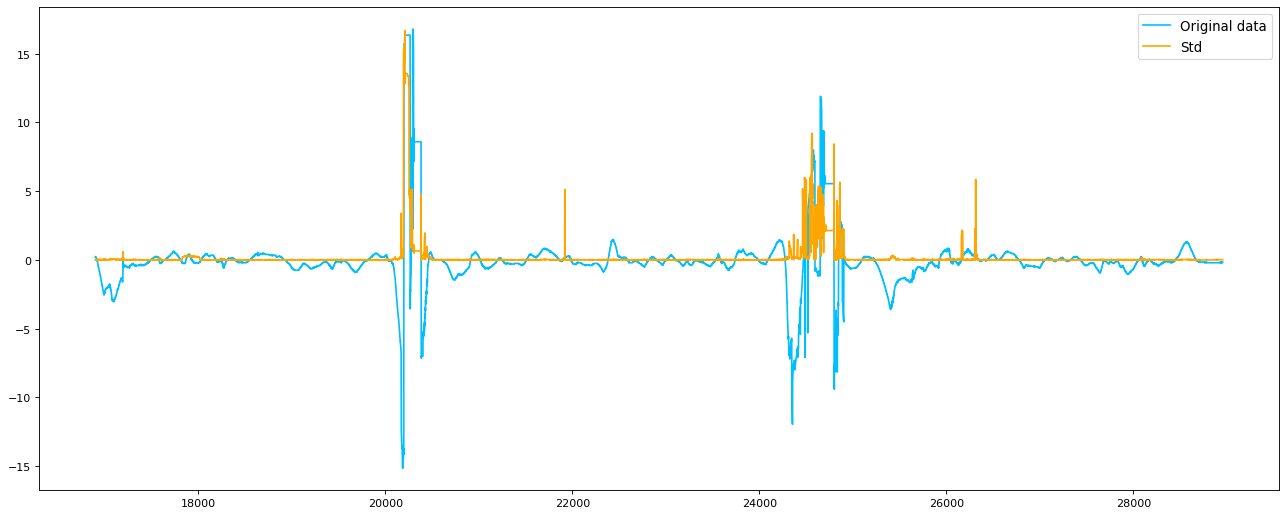

In [301]:
plot_statistics(lat_d_data, True, False, True)

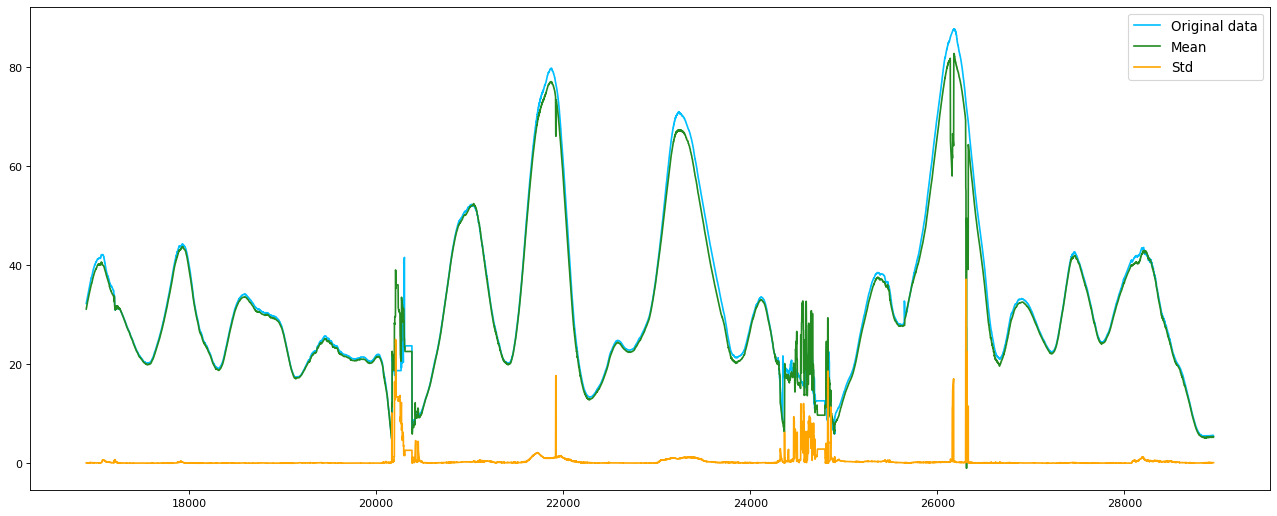

In [302]:
long_d_data = merge_and_calculate(ori, test_l, "OBJ_Long_D")
plot_statistics(long_d_data)

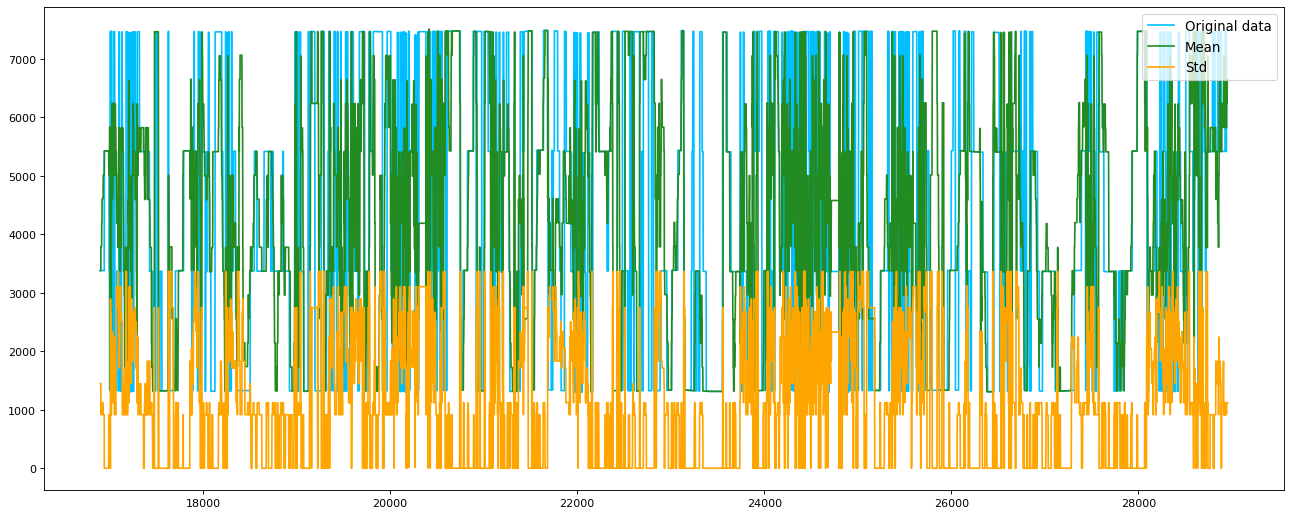

In [303]:
re_long_v_data = merge_and_calculate(ori, test_l, "OBJ_Re_Long_V")
plot_statistics(re_long_v_data)

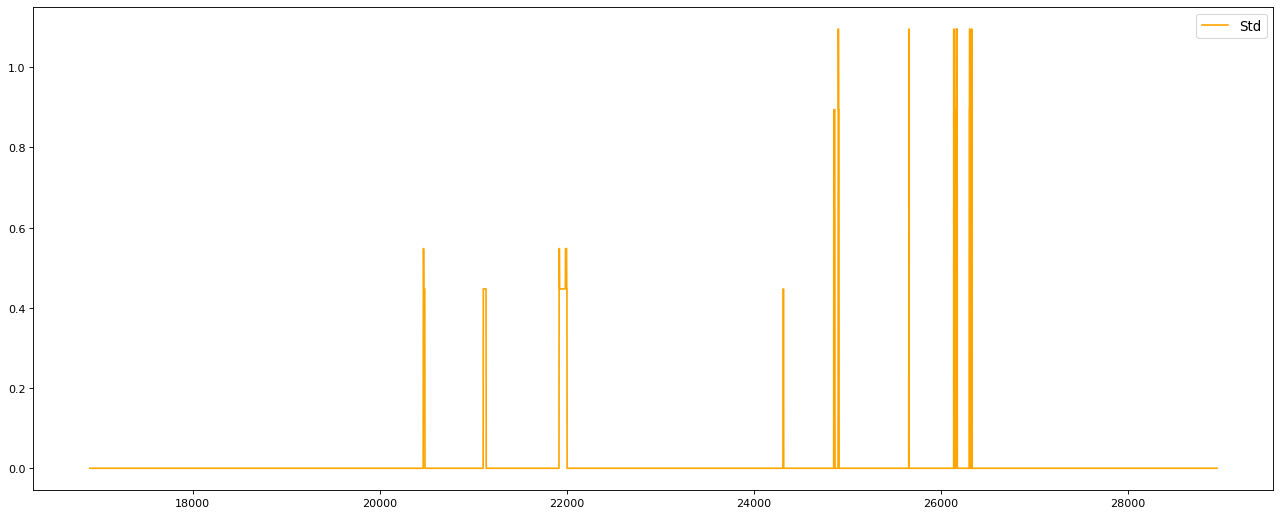

In [305]:
cipv_lost_data = merge_and_calculate(ori, test_l, "OBJ_CIPV_Lost")
plot_statistics(cipv_lost_data, False, False, True)

In [335]:
large_std_cam_id(cipv_lost_data, 0.8)

[24856.0,
 24857.0,
 24858.0,
 24859.0,
 24860.0,
 24861.0,
 24862.0,
 24863.0,
 24864.0,
 24865.0,
 24866.0,
 24867.0,
 24903.0,
 24904.0,
 24905.0,
 24906.0,
 24907.0,
 24908.0,
 24909.0,
 24910.0,
 24911.0,
 25659.0,
 26139.0,
 26160.0,
 26161.0,
 26162.0,
 26163.0,
 26164.0,
 26165.0,
 26166.0,
 26167.0,
 26169.0,
 26170.0,
 26171.0,
 26172.0,
 26173.0,
 26174.0,
 26175.0,
 26304.0,
 26305.0,
 26306.0,
 26307.0,
 26308.0,
 26309.0,
 26310.0,
 26311.0,
 26331.0]

In [363]:
t_id = covert_cam_id_to_time(ori, large_std_cam_id(cipv_lost_data, 0.8))

In [424]:
t_id

11768    328.607544
11769    328.628543
11770    328.648554
11771    328.691547
11772    328.711702
11773    328.730434
11774    328.771524
11775    328.791513
11776    328.831549
11777    328.851541
11778    328.872538
11779    328.914541
11815    329.900084
11816    329.939110
11817    329.960195
11818    329.980313
11819    330.021059
11820    330.044057
11821    330.063570
11822    330.084021
11823    330.122790
12571    350.873720
13047    364.207457
13068    364.785588
13069    364.806817
13070    364.827632
13071    364.869339
13072    364.889869
13073    364.910828
13074    364.931838
13075    364.972855
13076    365.012861
13077    365.056992
13078    365.076866
13079    365.116859
13080    365.139608
13081    365.159512
13082    365.200320
13211    368.764712
13212    368.805110
13213    368.824121
13214    368.866874
13215    368.888912
13216    368.910760
13217    368.930746
13218    368.973869
13237    369.528875
Name: T, dtype: float64